# Домашнее задание № 2
## Дедлайн &mdash; 2 AM 16 ноября 2017

## Задача 1. ALS vs градиентный спуск

### 1: Сгенерируйте случайную малоранговую матрицу $X$ размером $1000 \times 1000$ и ранга $100$
### 2: Решите следующую задачу оптимизации с помощью градиентного спуска (GD) по параметрам $U, V$ и с помощью метода ALS (Alternating Least Squares)
### $$ \min_{U, V} \| X - U^{\top}V\|^2_F. $$

Метод ALS заключается в следующем:

-задаётся начальное приближение $U_0$ и $V_0$
    
-фиксируется $U$ и ищется минимум по переменной $V$ соответственно
    
-фиксируется найденное значение $V$ и оптимизируется значение $U$
    
-и так далее до сходимости

Для GD с адаптивным шагом использовалась формула:

$$ F(x^{k+1}) \le F(x^{k}) - \epsilon ~ a^k ~ ||~ \nabla F(x^k) ~||^2 $$

Шаг GD $a^k$ умножается на $\delta$, пока это формула не будет удовлетворяться.

$\epsilon ~,~ \delta$ это фиксированные параметры.

ref: http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82%D0%BD%D0%BE%D0%B3%D0%BE_%D1%81%D0%BF%D1%83%D1%81%D0%BA%D0%B0


In [236]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm

def rand_matrix(n, rank):
    mat = 0.0 * np.eye(n)
    for i in range(rank):
        a = np.random.randn(n).reshape(1, n)
        b = np.random.randn(n).reshape(n, 1)
        mat = mat + b.dot(a)
        
    return mat

def GradientDescent(F, gradF_u, gradF_v, u0, v0, step_u0, step_v0, varyStep=False, stepDivideEps=0.95, stepEps=1e-1, eps=1e-4, maxiter=100):
    u = u0
    v = v0
    uv_hist = [F(u, v)]
    err_u = 1.0
    err_v = 1.0
    step_u = step_u0
    step_v = step_v0
    
    n_iter = 0
    while err_u > eps and err_v > eps and n_iter < maxiter:
        # from previous step
        uold = u
        vold = v
        
        # Step for u
        gradFu = gradF_u(u, v)
        Fuvold = F(u, v)
        u = u - step_u * gradFu
        # Choose step_u
        if varyStep:
            Fuv = F(u, v)
            err_u = norm(gradFu, 2)        
            while Fuv > Fuvold - stepEps*step_u*(err_u**2):
                step_u = step_u * stepDivideEps
                Fuv = F(uold - step_u * gradFu, v)
            # update for new step
            u = uold - step_u * gradFu
        
        # Step for v
        gradFv = gradF_v(u, v)
        Fuvold = F(u, v)
        v = v - step_v * gradFv
        # Choose step_v
        if varyStep:
            Fuv = F(u, v)
            err_v = norm(gradFv, 2)
            while Fuv > Fuvold - stepEps*step_v*(err_v**2):
                step_v = step_v * stepDivideEps
                Fuv = F(u, vold - step_v * gradFv)
            # update for new step
            v = vold - step_v * gradFv
                
        uv_hist.append(F(u, v))
        
        # errors
        err_u = norm(gradF_u(u, v), 2)
        err_v = norm(gradF_v(u, v), 2)
        
        n_iter = n_iter + 1      

        
    return u, v, uv_hist, n_iter

# Alternating Least Squares method
def ALS(F, gradF_u, gradF_v, zeroGradF_u, zeroGradF_v, u0, v0, zeroGradAreGiven=True, eps=1e-4, maxiter=100):
    u = u0
    v = v0
    uv_hist = [F(u, v)]
    err_u = 1.0
    err_v = 1.0
    
    n_iter = 0
    while err_u > eps and err_v > eps and n_iter < maxiter:
        if zeroGradAreGiven:
            #from previous step
            uold = u
            vold = v
            # v is fixed. Find u:
            u = zeroGradF_u(v)
            # u is fixed. Find v:
            v = zeroGradF_v(u)
            
            uv_hist.append(F(u, v))
            # errors
            err_u = norm(uold - u, 2) / norm(u, 2)
            err_v = norm(vold - v, 2) / norm(v, 2)
        else:
            # need to find u: gradF_u(u, v) = 0 and v: gradF_v(u, v) = 0, using Newton's method for example
            print("...")
            break
            
        n_iter = n_iter + 1
            
    return u, v, uv_hist, n_iter

# Generate matrix
n, rank = 100, 10

XU = np.random.rand(rank, n)
XV = np.random.rand(rank, n)
X = XU.T.dot(XV)

F = lambda u, v: np.linalg.norm(X - u.T.dot(v), ord='fro')
gradF_u = lambda u, v: -2.0 * v.dot(X.T - v.T.dot(u))
gradF_v = lambda u, v: -2.0 * u.dot(X - u.T.dot(v))

# return u, where u is a solution of gradF_u(u, v) = 0, where v is fixed
zeroGradF_u = lambda v: np.linalg.inv(v.dot(v.T)).dot(v.dot(X.T))  
# return v, where v is a solution of gradF_v(u, v) = 0, where u is fixed
zeroGradF_v = lambda u: np.linalg.inv(u.dot(u.T)).dot(u.dot(X))

print("Matrix and gradients are generated!")

Matrix and gradients are generated!


### 3: Сравните сходимость ALS и GD для этой задачи для различных размеров матриц U и V

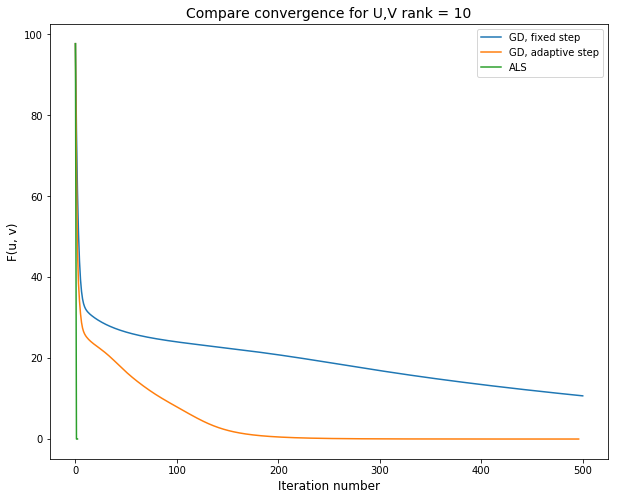

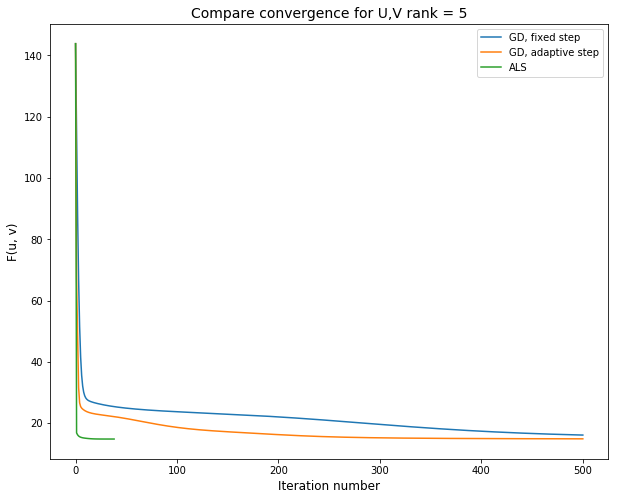

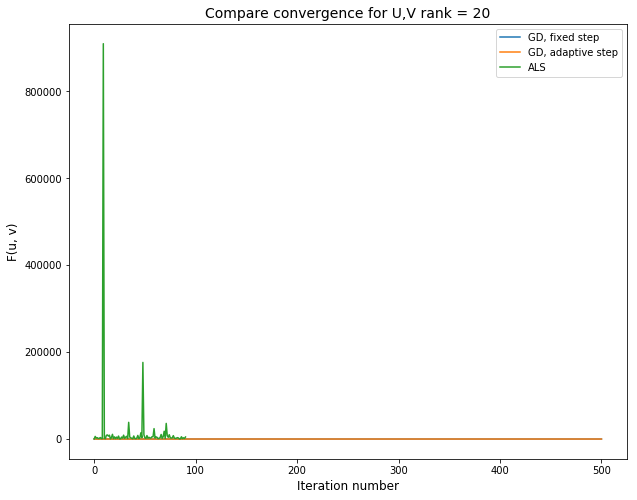

In [257]:
# Compare GD and ALS for different ranks

step_u_fixed = 5e-4
step_v_fixed = 5e-4
step_u_vary = 1.0
step_v_vary = 1.0
step_divide_eps = 0.95
step_eps = 1e-3
iters = 500

r = int(rank)
u0 = np.random.rand(r, n)
v0 = np.random.rand(r, n)

u, v, histGD, niters = GradientDescent(F, gradF_u, gradF_v, u0, v0, step_u_fixed, step_v_fixed, maxiter=iters)
#print("GD, fixed step. iters = ", niters, " F = ", F(u, v))

u, v, histVaryGD, niters = GradientDescent(F, gradF_u, gradF_v, u0, v0, step_u_vary, step_v_vary, varyStep=True, stepDivideEps=step_divide_eps, stepEps=step_eps, maxiter=iters)
#print("GD, vary step. iters = ", niters, " F = ", F(u, v))

u, v, histALS, niters = ALS(F, gradF_u, gradF_v, zeroGradF_u, zeroGradF_v, u0, v0, maxiter=iters)
#print("ALS. iters = ", niters, " F = ", F(u, v))

plt.figure(figsize=(10, 8))
plt.plot(histGD, label="GD, fixed step")
plt.plot(histVaryGD, label="GD, adaptive step")
plt.plot(histALS, label="ALS")
plt.title("Compare convergence for U,V rank = " + str(r), fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.ylabel("F(u, v)", fontsize=12)
plt.legend()

r = int(rank / 2)
u0 = np.random.rand(r, n)
v0 = np.random.rand(r, n)

u, v, histGD, niters = GradientDescent(F, gradF_u, gradF_v, u0, v0, step_u_fixed, step_v_fixed, maxiter=iters)
#print("GD, fixed step. iters = ", niters, " F = ", F(u, v))

u, v, histVaryGD, niters = GradientDescent(F, gradF_u, gradF_v, u0, v0, step_u_vary, step_v_vary, varyStep=True, stepDivideEps=step_divide_eps, stepEps=step_eps, maxiter=iters)
#print("GD, vary step. iters = ", niters, " F = ", F(u, v))

u, v, histALS, niters = ALS(F, gradF_u, gradF_v, zeroGradF_u, zeroGradF_v, u0, v0, maxiter=iters)
#print("ALS. iters = ", niters, " F = ", F(u, v))

plt.figure(figsize=(10, 8))
plt.plot(histGD, label="GD, fixed step")
plt.plot(histVaryGD, label="GD, adaptive step")
plt.plot(histALS, label="ALS")
plt.title("Compare convergence for U,V rank = " + str(r), fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.ylabel("F(u, v)", fontsize=12)
plt.legend()

r = int(2 * rank)
u0 = np.random.rand(r, n)
v0 = np.random.rand(r, n)

u, v, histGD, niters = GradientDescent(F, gradF_u, gradF_v, u0, v0, step_u_fixed, step_v_fixed, maxiter=iters)
#print("GD, fixed step. iters = ", niters, " F = ", F(u, v))

u, v, histVaryGD, niters = GradientDescent(F, gradF_u, gradF_v, u0, v0, step_u_vary, step_v_vary, varyStep=True, stepDivideEps=step_divide_eps, stepEps=step_eps, maxiter=iters)
#print("GD, vary step. iters = ", niters, " F = ", F(u, v))

u, v, histALS, niters = ALS(F, gradF_u, gradF_v, zeroGradF_u, zeroGradF_v, u0, v0, maxiter=iters)
#print("ALS. iters = ", niters, " F = ", F(u, v))

plt.figure(figsize=(10, 8))
plt.plot(histGD, label="GD, fixed step")
plt.plot(histVaryGD, label="GD, adaptive step")
plt.plot(histALS, label="ALS")
plt.title("Compare convergence for U,V rank = " + str(r), fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.ylabel("F(u, v)", fontsize=12)
plt.legend()


### 4: Исследуйте зависимость от начального приближения и объясните её

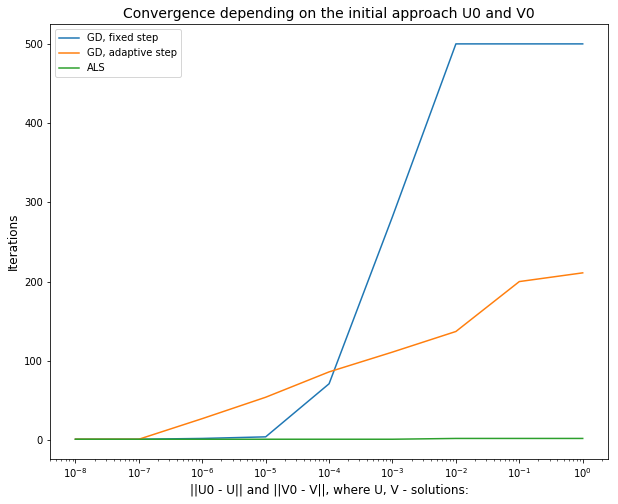

In [258]:
# How depends from initional values u0, v0?

step_u_fixed = 1e-3
step_v_fixed = 1e-3
step_u_vary = 1.0
step_v_vary = 1.0
step_divide_eps = 0.95
step_eps = 1e-3
iters = 500

r = int(rank)
err_UV = []
niters_GD = []
niters_VaryGD = []
niters_ALS = []
for i in range(0, 9):
    u0 = np.random.rand(r, n)
    v0 = np.random.rand(r, n)

    u0 = XU + u0 * (10.0**(-i) / norm(u0, 2))
    v0 = XV + v0 * (10.0**(-i) / norm(v0, 2))
    err_UV.append(10.0**(-i))
    #print("||u0 - u|| and ||v0 - v||, where u, v - solutions: ", norm(u0 - XU, 2), norm(v0 - XV, 2))
    
    u, v, histGD, niters = GradientDescent(F, gradF_u, gradF_v, u0, v0, step_u_fixed, step_v_fixed, maxiter=iters)
    niters_GD.append(niters)
    
    u, v, histVaryGD, niters = GradientDescent(F, gradF_u, gradF_v, u0, v0, step_u_vary, step_v_vary, varyStep=True, stepDivideEps=step_divide_eps, stepEps=step_eps, maxiter=iters)
    niters_VaryGD.append(niters)
    
    u, v, histALS, niters = ALS(F, gradF_u, gradF_v, zeroGradF_u, zeroGradF_v, u0, v0, maxiter=iters)
    niters_ALS.append(niters)
  
plt.figure(figsize=(10, 8))
plt.plot(err_UV, niters_GD, label="GD, fixed step")
plt.plot(err_UV, niters_VaryGD, label="GD, adaptive step")
plt.plot(err_UV, niters_ALS, label="ALS")
plt.title("Convergence depending on the initial approach U0 and V0", fontsize=14)
plt.xlabel("||U0 - U|| and ||V0 - V||, where U, V - solutions:", fontsize=12)
plt.xscale("log")
plt.ylabel("Iterations", fontsize=12)
plt.legend()

Чем ближе начальное приближение к решению задачи - тем требуется меньше итераций для метода GD. Это видно из графика.
Для быстрой сходимости GD важно попасть приближением рядом с решением задачи. Иначе алгоритм может сходится гораздо дольше.

### 5: Рассмотрите различные способы выбора шага в градиентном спуске и сделайте вывод о применимости каждого из них

GD, fixed step. iters =  4  F =  inf
GD, adaptive step. iters =  464  F =  6.45941653073e-05

!!! GD, Fixed step - no convergence !!!


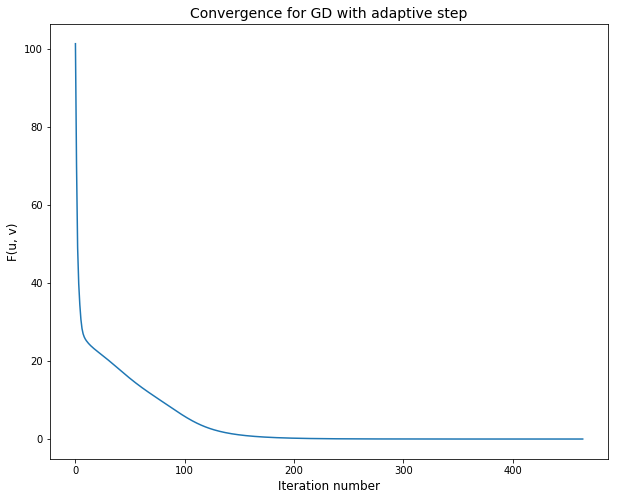

In [256]:
# GD: Fixed step vs Adaptive step

step_u_fixed = 1e-2
step_v_fixed = 1e-2
step_u_vary = 1.0
step_v_vary = 1.0
step_divide_eps = 0.95
step_eps = 1e-3
iters = 500

r = int(rank)
u0 = np.random.rand(r, n)
v0 = np.random.rand(r, n)

u, v, histGD, niters = GradientDescent(F, gradF_u, gradF_v, u0, v0, step_u_fixed, step_v_fixed, maxiter=iters)
print("GD, fixed step. iters = ", niters, " F = ", F(u, v))

u, v, histVaryGD, niters = GradientDescent(F, gradF_u, gradF_v, u0, v0, step_u_vary, step_v_vary, varyStep=True, stepDivideEps=step_divide_eps, stepEps=step_eps, maxiter=iters)
print("GD, adaptive step. iters = ", niters, " F = ", F(u, v))

print("")
print("!!! GD, Fixed step - no convergence !!!")

plt.figure(figsize=(10, 8))
#plt.plot(histGD, label="GD, fixed step")
plt.plot(histVaryGD, label="GD, adaptive step")
plt.title("Convergence for GD with adaptive step", fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.ylabel("F(u, v)", fontsize=12)
#plt.legend()

Если выбирать слишком большой шаг, то GD с фиксированныи шагом не будет сходится. В то время как GD с адаптивным шагом - сходится, это видно на графике. 

GD с адаптивным шагом лучше как раз потому что он не так чувствителен к набору параметров, в отличии от GD с фиксированным шагом, который очень чувствителен к шагу.

## Задача 2. PageRank

### 1: Опишите алгоритм PageRank (введите все необходимые обозначения)
### 2: Как связаны задачи нахождения PageRank'а и поиска максимального собственноо вектора и соответствующего ему собственного значения и почему?

#### PageRank
Consider graph $G = (V, E)$, where $V$ is set of nodes and $E$ is of edges. Assume $V = \{1, ..., n\}$ and write $i \rightarrow j$ to indicate that $(i, j) \in E$. The graph $G$ can be described by adjacency matrix $A \in R^{n \times n}$, such that $A_{ij} = 1$ if $j \rightarrow  i$ and $A_{ij} = 0$ otherwise.

The original formula by S. Brin and L. Page defines PageRank vector $\pi = (\pi_1, ..., \pi_n)^T$ of a graph $G$ as the solution of the following linear system:

$$ \pi_i = (1 - a) + a \sum_{j: j \rightarrow i} \frac{\pi_j}{d_j^{out}} $$

where $d_j^{out}$ is a number of outgoing edges from node $j$ of a graph $G$; $a \in (0, 1)$ is fixed constant called the damping factor, originally set to $a = 0.85$.

In Matrix form:

$$ (I - aM)\pi = (1 - a)e $$

where $M$ - matrix with non-negative elements (M is called link matrix) which is defined as:

\begin{equation}
  M_{ij} = \left\{
      \begin{array}{ccc}
          \displaystyle{\frac{A_{ij}}{d_j^{out}} ~~ \text{if} ~~  d_j^{out} > 0 } \\
          \displaystyle{0 ~~ otherwise}
      \end{array}
      \right.
\end{equation}

where $A$ - is a adjacency matrix of a graph $G$.

#### Main Theorem

(as a consequence of the Perron–Frobenius theorem)

Let $\Gamma \in R^{n \times n}$ be the positive matrix, $0 < a < 1$:
$$ \Gamma = aM + \frac{1 - a}{n} e e^T $$


Then, $\rho(\Gamma) = 1$ and the vector $\pi$ is a Perron eigenvector.

$\Gamma$ is called Google Matrix

(Note: $\rho(\Gamma)$ the Perron eigenvalue of $\Gamma$ and any associated positive eigenvector is a Perron eigenvector)

### 3: Реализуйте степенной метод нахождения максимального собственного вектора

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import scipy.sparse as spsp
import scipy.sparse.linalg as splinalg

from scipy import linalg
from scipy.linalg import norm

def rand_matrix(n, rank):
    mat = 0.0 * np.eye(n)
    for i in range(rank):
        a = np.random.randn(n).reshape(1, n)
        b = np.random.randn(n).reshape(n, 1)
        mat = mat + b.dot(a)
        
    return mat


def PowerMethod(A, y0, eps=1e-4, maxiter=100):
    x = y0 / norm(y0, 2)
    l = 0.0
    
    err = 1.0
    hist = [l]
    
    n_iter = 0
    while err > eps and n_iter < maxiter:
        lold = l
        
        y = A.dot(x)
        x = y / norm(y, 2)
        
        l = x.T.dot(A.dot(x))
        
        #err = abs(l - lold)
        hist.append(l)
        
        n_iter = n_iter + 1
        
    return x, l, n_iter, hist

# Power Method for Google matrix
def PM_GoogleMatrix(M, a, n, y0, eps=1e-4, maxiter=100):
    x = y0 / norm(y0, 2)
    l = 0.0
    
    err = 1.0
    hist = [l]
    
    e = np.ones((n, 1))

    n_iter = 0
    while err > eps and n_iter < maxiter:
        lold = l
        
        y = a * M.dot(x) + ((1.0 - a) / n) * e.dot((e.T.dot(x)))
        x = y / norm(y, 2)
        l = x.T.dot(M.dot(x))
        
        #err = abs(l - lold)
        hist.append(l)
        
        n_iter = n_iter + 1
        
    return x, l, n_iter, hist

Iters:  100  lymbda:  -4.13678597609
Lymbdas from np.linalg.eig:  [-4.13684964 -2.15633927  3.91006829  2.75576822  2.61116464  2.01343294
  0.77852164 -0.71396622 -0.60625462 -0.34623032]


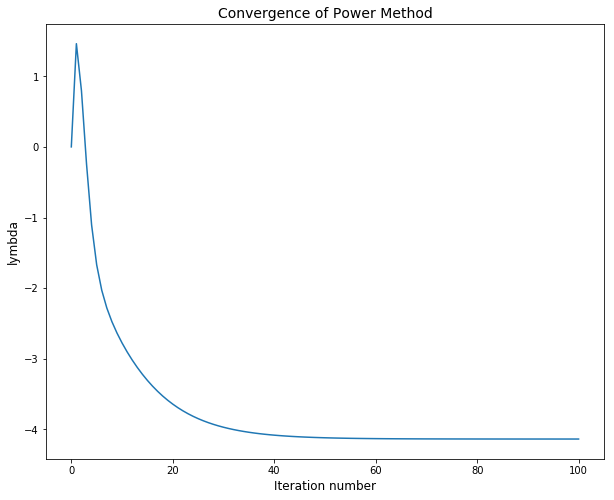

In [108]:
# Test for Power Method, compare with linalg.eig

n = 10
A = np.random.randn(n, n)
# do symmetric
A = (A + A.T) / 2.0 

v0 = np.random.randn(n).reshape(n, 1)
v, l, niters, hist = PowerMethod(A, v0, maxiter=100)
print("Iters: ", niters, " lymbda: ", l[0, 0])

L, V = np.linalg.eig(A)
print("Lymbdas from np.linalg.eig: ", L)

plt.figure(figsize=(10, 8))
plt.plot(hist)
plt.title("Convergence of Power Method", fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.ylabel("lymbda", fontsize=12)


### 4: Найдите с помощью степенного метода TOP-10 статей по величине PageRank'a по физике высоких энергий в соответствии с [графом](https://snap.stanford.edu/data/cit-HepTh.html). Результат должен быть воспроизводим, используйте разреженные матрицы для работы с матрицей смежности графа

In [109]:
# Read graph and build matrix

Graph = {}
NodeMap = {}

k = 0

with open('Cit-HepTh.txt') as f:
    for line in f:
        NodeFrom, NodeTo = line.split()
        NodeFrom, NodeTo = int(NodeFrom), int(NodeTo)
        
        if NodeMap.get(NodeFrom, -1) == -1:
            NodeMap[NodeFrom] = k
            k = k + 1
        
        if NodeMap.get(NodeTo, -1) == -1:
            NodeMap[NodeTo] = k
            k = k + 1
        
        if Graph.get(NodeFrom, 0) == 0:
            Graph[NodeFrom] = [NodeTo]
        else:
            Graph[NodeFrom].append(NodeTo)

n = len(NodeMap.values())
print("Nodes: ", n, k)

# link matrix
M = spsp.lil_matrix((n, n))

for nodeFrom in Graph.keys():
    NodesTo = Graph[nodeFrom]
    d_out = len(NodesTo)
    
    for nodeTo in NodesTo:
        # if j->i then Aij = 1
        M[NodeMap[nodeTo], NodeMap[nodeFrom]] = (1.0 / d_out)

print("Nonzero: ", M.nnz)
M.tocsr()

print("Building Link Matrix M is successed!")


Nodes:  27770 27770
Nonzero:  352807
Build Link Matrix M is successed!


In [110]:
# Find Perron eigenvalue and Perron eigenvector 

a = 0.85 # damping factor

print("n and a: ", n, a)
print("--------------------------------------------------")

#L, V = splinalg.eigs(M, k=1, tol=1e-2, maxiter=1000)
#print(L)

v0 = np.abs(np.random.randn(n).reshape(n, 1))
v1, l1, niters1, hist1 = PM_GoogleMatrix(M, a, n, v0, maxiter=100)
print("Iters: ", niters1, " Lymbda: ", l1[0, 0])

v0 = np.ones((n, 1))
v2, l2, niters2, hist2 = PM_GoogleMatrix(M, a, n, v0, maxiter=100)
print("Iters: ", niters2, " Lymbda: ", l2[0, 0])


n and a:  27770 0.85
--------------------------------------------------
Iters:  100  Lymbda:  1.01205988303
Iters:  100  Lymbda:  1.01206401233


--------------------------------------------------------
Top 10 for v1
1 PageRank:  2573.42306928  ID Node:  9207016
2 PageRank:  2558.69850026  ID Node:  9201015
3 PageRank:  179.395646898  ID Node:  9407087
4 PageRank:  137.985538411  ID Node:  9503124
5 PageRank:  127.13760417  ID Node:  9402044
6 PageRank:  123.719600259  ID Node:  9510017
7 PageRank:  105.054654141  ID Node:  9410167
8 PageRank:  96.5844474794  ID Node:  9402002
9 PageRank:  93.0778988191  ID Node:  9205027
10 PageRank:  89.4311420254  ID Node:  9205068
--------------------------------------------------------
Top 10 for v2
1 PageRank:  2573.04689936  ID Node:  9207016
2 PageRank:  2556.7791621  ID Node:  9201015
3 PageRank:  179.395395091  ID Node:  9407087
4 PageRank:  137.985333389  ID Node:  9503124
5 PageRank:  127.137393836  ID Node:  9402044
6 PageRank:  123.719431578  ID Node:  9510017
7 PageRank:  105.054490265  ID Node:  9410167
8 PageRank:  96.5842864199  ID Node:  9402002
9 PageRank:  93.0777178641  ID 

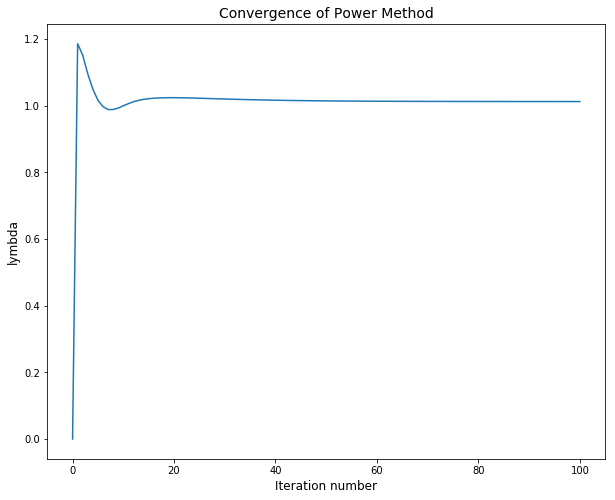

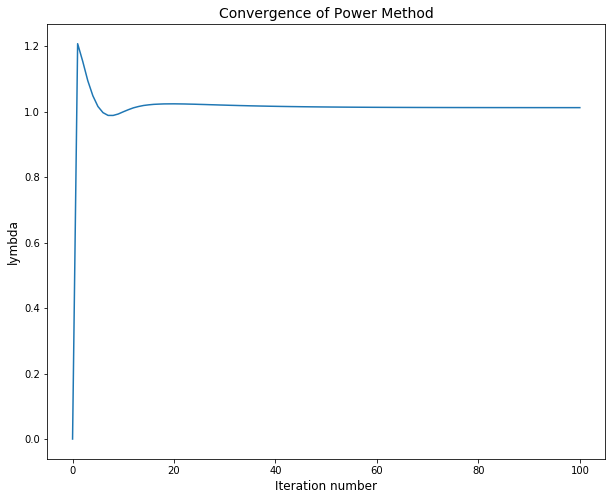

In [111]:
# Show Top 10 and show convergence

#normalize v: eT * v = n
v1 = (v1 / norm(v1, 1)) * n
v2 = (v2 / norm(v2, 1)) * n

#idmax = np.argmax(v1)
#prmax = v1[idmax, 0]
#print("id max and pageRank max: ", idmax, prmax)
#print("ID node: ", list(NodeMap.keys())[list(NodeMap.values()).index(idmax)])

print("--------------------------------------------------------")
vsort = np.argsort(v1[:,0])
topv = vsort[-10:][::-1]
print("Top 10 for v1")
num = 1
for i in topv:
    print(num, "PageRank: ", v1[i, 0], " ID Node: ", list(NodeMap.keys())[list(NodeMap.values()).index(i)])
    num = num + 1
    
plt.figure(figsize=(10, 8))
plt.plot(hist1)
plt.title("Convergence of Power Method", fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.ylabel("lymbda", fontsize=12)

print("--------------------------------------------------------")
vsort = np.argsort(v2[:,0])
topv = vsort[-10:][::-1]
print("Top 10 for v2")
num = 1
for i in topv:
    print(num, "PageRank: ", v2[i, 0], " ID Node: ", list(NodeMap.keys())[list(NodeMap.values()).index(i)])
    num = num + 1

plt.figure(figsize=(10, 8))
plt.plot(hist2)
plt.title("Convergence of Power Method", fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.ylabel("lymbda", fontsize=12)


### 5: Сравните теоретическую и экспериментальную сходимость степенного метода для этого графа. Нарисуйте график и объясните, почему он выглядит именно так?

## Задача 3. Регуляризация

1. Сгенерируйте случайную малоранговую матрицу $X$ $500 \times 100$ ранга $10$
2. Сгенерируйте случайный вектор $w$ размера $100$ и целевой вектор 
$$
y = Xw + \varepsilon,
$$
где $\varepsilon$ - вектор с элементами из нормального распределения с нулевым средним и дисперсией $0.01$. 
3. Сравните разреженность и точность решения, которое дают методы регуляризации рассмотренные на лекции. Сделайте вывод об их эффективности. Рассмотрите, как автоматический подбор параметра регуляризации, так и эвристический подбор. Сравните эффективность методов. 
4. Проведите аналогичный эксперимент, но на данных, в которых целевой вектор сгенерирован так, что он хорошо аппроксимируется как одним признаком, так и линейной комбинацией двух или трёх других признаков. Выделяют ли методы регуляризации подобные зависимости в данных? Почему?
5. Добавьте в сгенерированную выборку несколько (5-10) выбросов, то есть таких строк и соответствующих им значений в $y$, что они не подчиняются ранее заданному закону.
6. Проверьте как изменится точность решения задачи для ранее рассмотренных методов
7. Сравните предыдущие методы регуляризации с [регуляризацией Huber'a](https://en.wikipedia.org/wiki/Huber_loss). Какой способ устойчивее к выбросам и почему?
8. Получите аналитическое решение задачи
$$
\min_w \|Xw - y\|^2_2 + \| \lambda \odot w \|^2_2,
$$
где $\lambda$ - вектор такой же размерности, что и $w$, $\odot$ означает поэлементное умножение двух векторов

In [3]:
# Your code is here